In [12]:
import sys
import os
sys.path.append(os.path.abspath(".."))


In [13]:
from src.data_preparation import load_preprocess_data, create_sequences


In [64]:
scaler, data_scaled, labels = load_preprocess_data("C:/Users/Lenovo/Desktop/financial-anomaly-lstm-autoencoder/data/raw/creditcard.csv")
print("Scaled data shape: ", data_scaled.shape)
print("Labeled data shape: ", labels.shape)
print(labels[541])

Scaled data shape:  (284807, 30)
Labeled data shape:  (284807,)
1


In [17]:
X, y = create_sequences(data=data_scaled, labels=labels)
print("Sequences shape:", X.shape)
print("Sequence labels shape:", y.shape)

Sequences shape: (284797, 10, 30)
Sequence labels shape: (284797,)


In [42]:
print("First sequence: ", X[0])
print("First sequence label: ", y[0])

First sequence:  [[0.00000000e+00 9.35192337e-01 7.66490419e-01 8.81364903e-01
  3.13022659e-01 7.63438735e-01 2.67668642e-01 2.66815176e-01
  7.86444198e-01 4.75311734e-01 5.10600482e-01 2.52484319e-01
  6.80907625e-01 3.71590602e-01 6.35590530e-01 4.46083696e-01
  4.34392391e-01 7.37172553e-01 6.55065861e-01 5.94863228e-01
  5.82942230e-01 5.61184389e-01 5.22992116e-01 6.63792975e-01
  3.91252676e-01 5.85121795e-01 3.94556792e-01 4.18976135e-01
  3.12696634e-01 5.82379309e-03]
 [0.00000000e+00 9.78541955e-01 7.70066651e-01 8.40298490e-01
  2.71796491e-01 7.66120336e-01 2.62191698e-01 2.64875439e-01
  7.86298353e-01 4.53980968e-01 5.05267346e-01 3.81187722e-01
  7.44341569e-01 4.86190176e-01 6.41219007e-01 3.83839664e-01
  4.64105178e-01 7.27793983e-01 6.40681094e-01 5.51930422e-01
  5.79529753e-01 5.57839915e-01 4.80236960e-01 6.66937823e-01
  3.36439996e-01 5.87290252e-01 4.46012969e-01 4.16345145e-01
  3.13422663e-01 1.04705276e-04]
 [3.12500000e-02 9.35217023e-01 7.53117667e-01 8.

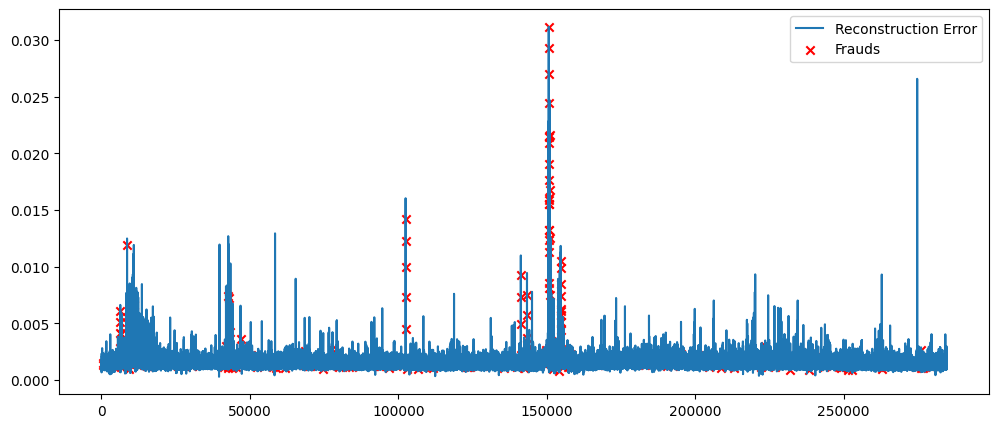

In [43]:
import numpy as np
import matplotlib.pyplot as plt

errors = np.load("../outputs/errors.npy")
y = np.load("../outputs/sequence_labels.npy")

plt.figure(figsize=(12,5))
plt.plot(errors, label="Reconstruction Error")
plt.scatter(np.where(y==1), errors[y==1], color='r', marker='x', label="Frauds")
plt.legend()
plt.savefig("../outputs/plots/reconstruction_errors.png", dpi=300, bbox_inches='tight')

plt.show()


In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


Epoch [1/5], Loss: 0.003046
Epoch [2/5], Loss: 0.001637
Epoch [3/5], Loss: 0.001583
Epoch [4/5], Loss: 0.001538
Epoch [5/5], Loss: 0.001489


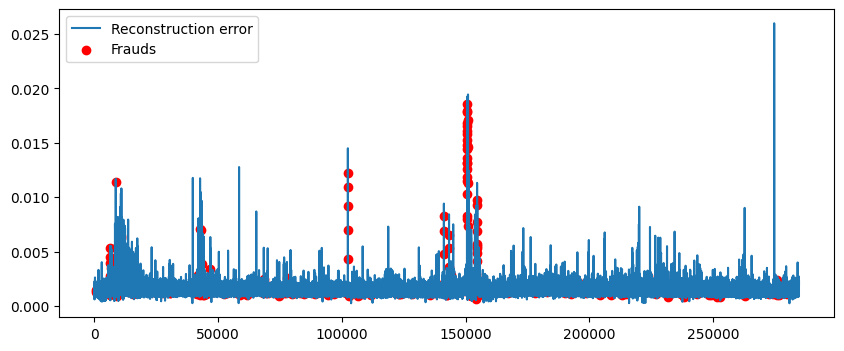

In [67]:
from src.data_preparation import load_preprocess_data, create_sequences
from src.train import train_model
from src.detect import compute_reconstruction_errors
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


# Load & preprocess
scaler, data_scaled, labels = load_preprocess_data("C:/Users/Lenovo/Desktop/financial-anomaly-lstm-autoencoder/data/raw/creditcard.csv")
X, y = create_sequences(data_scaled, labels, seq_length=10)

# Only train on normal transactions
X_train = X[y == 0]

# Train model
model = train_model(X_train, num_epochs=5)

# Compute reconstruction errors on all data
errors = compute_reconstruction_errors(model, X)

# Plot errors vs true frauds
plt.figure(figsize=(10,4))
plt.plot(errors, label="Reconstruction error")
plt.scatter(np.where(y==1), errors[y==1], color='r', label="Frauds")
plt.legend()
plt.savefig("../outputs/plots/reconstruction_errors.png", dpi=300, bbox_inches='tight')

plt.show()



In [68]:
threshold = np.percentile(errors, 95)
predicted = (errors > threshold).astype(int)

precision = precision_score(y, predicted)
recall = recall_score(y, predicted)
f1 = f1_score(y, predicted)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y, predicted))

Precision: 0.0067
Recall: 0.1951
F1 Score: 0.0130
Confusion Matrix:
[[270161  14144]
 [   396     96]]


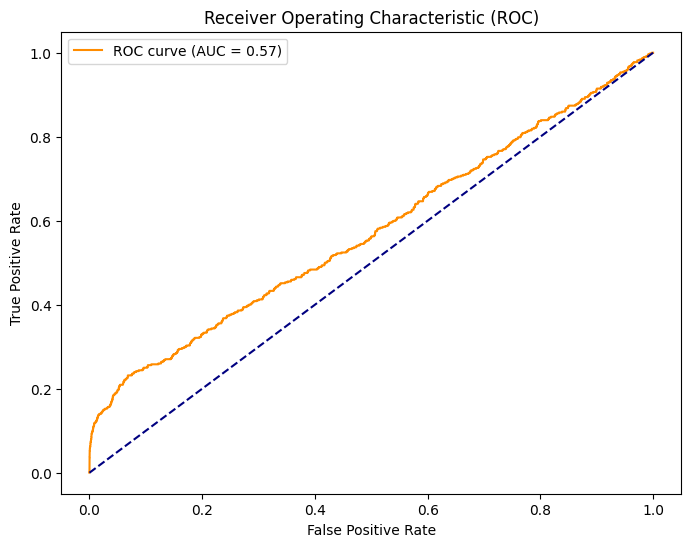

In [69]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y, errors)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("Receiver Operating Characteristic (ROC)")
plt.savefig("../outputs/plots/roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()


In [70]:
model.state_dict()

OrderedDict([('encoder.weight_ih_l0',
              tensor([[-0.0017, -0.0537,  0.0387,  ...,  0.1495,  0.0531,  0.0402],
                      [-0.7911,  0.1560,  0.0628,  ...,  0.1524,  0.1344, -0.4525],
                      [-0.2780,  0.0381,  0.0199,  ...,  0.0050, -0.0115,  0.2478],
                      ...,
                      [-0.0745, -0.0355, -0.0098,  ..., -0.0952,  0.1154,  0.1103],
                      [-0.1830,  0.2249,  0.0442,  ...,  0.0486,  0.2555,  0.0733],
                      [ 0.3192,  0.1766, -0.1162,  ...,  0.0919, -0.1121,  0.0378]],
                     device='cuda:0')),
             ('encoder.weight_hh_l0',
              tensor([[ 0.1066,  0.0567, -0.0950,  ...,  0.0326, -0.0415, -0.0218],
                      [-0.2475, -0.0672,  0.2080,  ...,  0.0272, -0.4678,  0.2364],
                      [ 0.0277,  0.0228, -0.0600,  ...,  0.0412, -0.0233,  0.0809],
                      ...,
                      [-0.1284,  0.1181, -0.0608,  ..., -0.1362, -0.1690,

In [71]:
import torch
import os

os.makedirs("financial-anomaly-lstm-autoencoder/outputs/models", exist_ok=True)


In [72]:
torch.save(model.state_dict(), "../outputs/models/lstm_autoencoder.pth")


In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)


cuda


LSTMAutoencoder(
  (encoder): LSTM(30, 64, batch_first=True)
  (decoder): LSTM(64, 30, batch_first=True)
)

## Testing one transaction from the dataset to check the model's performance

In [73]:
import torch
import numpy as np

# Example dummy data
last_9_txs = data_scaled[-9:, :]   # take last 9 normal transactions
new_tx = data_scaled[541, :]       # or any new transaction

sequence = np.vstack([last_9_txs, new_tx.reshape(1, -1)])  # shape (10, 30)
sequence_tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 10, 30)

# Compute reconstruction error
model.eval()
with torch.no_grad():
    reconstructed = model(sequence_tensor)
    loss = torch.mean((reconstructed - sequence_tensor)**2, dim=(1,2))  # shape (1,)

# Compare with your threshold
threshold = np.percentile(errors, 95)
if loss.item() > threshold:
    print(f"🚨 Anomaly detected! Reconstruction error: {loss.item():.4f}")
else:
    print(f"✅ Looks normal. Reconstruction error: {loss.item():.4f}")


🚨 Anomaly detected! Reconstruction error: 0.0023
